<a href="https://colab.research.google.com/github/JumanaRahim/Nullclass-Internship/blob/main/TASK%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, Dataset



In [12]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

In [13]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [14]:
class CIFAR10Colorization(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        gray = img
        color = torchvision.transforms.ToTensor()(torchvision.transforms.ToPILImage()(img).convert("RGB"))
        return gray, color


In [15]:
trainset_gray_color = CIFAR10Colorization(trainset)
testset_gray_color = CIFAR10Colorization(testset)

trainloader = DataLoader(trainset_gray_color, batch_size=64, shuffle=True)
testloader = DataLoader(testset_gray_color, batch_size=64, shuffle=False)



In [16]:
class ColorizationAutoencoder(nn.Module):
    def __init__(self):
        super(ColorizationAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),

            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hyperparameters = [
    {"learning_rate": 0.001, "batch_size": 32},
    {"learning_rate": 0.0005, "batch_size": 64},
    {"learning_rate": 0.0001, "batch_size": 128}
]

In [18]:
def train_model(learning_rate, batch_size, num_epochs=5):
    trainloader = DataLoader(trainset_gray_color, batch_size=batch_size, shuffle=True)
    model = ColorizationAutoencoder().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_history = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        for gray_imgs, color_imgs in trainloader:
            gray_imgs, color_imgs = gray_imgs.to(device), color_imgs.to(device)

            optimizer.zero_grad()
            outputs = model(gray_imgs)
            loss = criterion(outputs, color_imgs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(trainloader)
        train_loss_history.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    return train_loss_history


In [19]:
results = {}

for hp in hyperparameters:
    print(f"\nTraining with LR = {hp['learning_rate']}, Batch = {hp['batch_size']}")

    start_time = time.time()
    loss_history = train_model(hp["learning_rate"], hp["batch_size"], num_epochs=3)
    elapsed_time = time.time() - start_time

    results[(hp["learning_rate"], hp["batch_size"])] = {
        "loss": loss_history,
        "time": elapsed_time
    }

    print(f"Training completed in {elapsed_time:.2f} sec")



Training with LR = 0.001, Batch = 32
Epoch [1/3], Loss: 0.0043
Epoch [2/3], Loss: 0.0019
Epoch [3/3], Loss: 0.0014
Training completed in 1226.55 sec

Training with LR = 0.0005, Batch = 64
Epoch [1/3], Loss: 0.0067
Epoch [2/3], Loss: 0.0032
Epoch [3/3], Loss: 0.0025
Training completed in 1197.80 sec

Training with LR = 0.0001, Batch = 128
Epoch [1/3], Loss: 0.0141
Epoch [2/3], Loss: 0.0063
Epoch [3/3], Loss: 0.0052
Training completed in 1185.42 sec


In [20]:
plt.figure(figsize=(10, 5))

for (lr, bs), data in results.items():
    loss_values = data.get("loss", [])

<Figure size 1000x500 with 0 Axes>

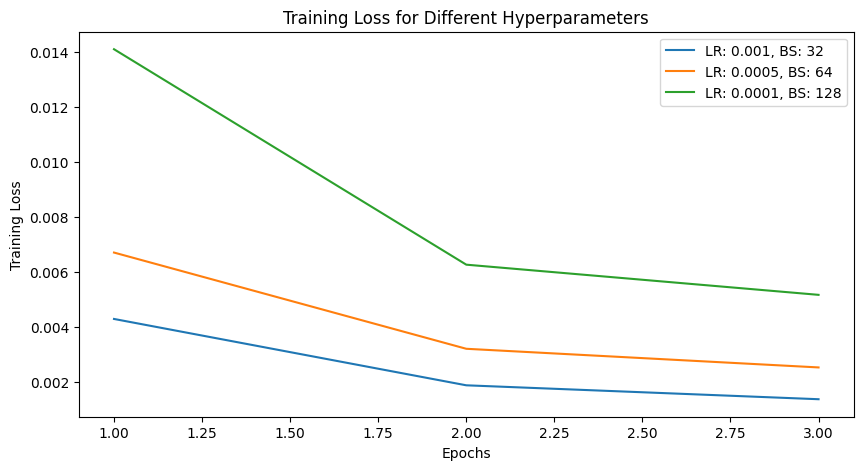

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for (lr, bs), data in results.items():
    loss_values = data.get("loss", [])

    if isinstance(loss_values, list) and all(isinstance(i, (int, float)) for i in loss_values):
        plt.plot(range(1, len(loss_values) + 1), loss_values, label=f"LR: {lr}, BS: {bs}")
    else:
        print(f"Warning: Invalid loss data for LR={lr}, BS={bs}: {loss_values}")

# Labels and title
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss for Different Hyperparameters")
plt.legend()
plt.show()



In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np

def train_model(learning_rate, batch_size, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainloader = DataLoader(trainset_gray_color, batch_size=batch_size, shuffle=True)

    model = ColorizationAutoencoder().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_history = []
    all_preds = []
    all_labels = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        for gray_imgs, color_imgs in trainloader:
            gray_imgs, color_imgs = gray_imgs.to(device), color_imgs.to(device)

            optimizer.zero_grad()
            outputs = model(gray_imgs)
            loss = criterion(outputs, color_imgs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Convert continuous pixel outputs to class labels (color categories)
            pred_classes = (outputs * 255).byte().cpu().numpy().flatten()
            true_classes = (color_imgs * 255).byte().cpu().numpy().flatten()

            all_preds.extend(pred_classes)
            all_labels.extend(true_classes)

        avg_loss = total_loss / len(trainloader)
        train_loss_history.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Convert to NumPy arrays for metric calculations
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute Performance Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=1)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=1)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("\n📌 **Final Model Performance:**")
    print(f"✅ Accuracy: {accuracy * 100:.2f}%")
    print(f"✅ Precision: {precision:.4f}")
    print(f"✅ Recall: {recall:.4f}")
    print("✅ Confusion Matrix:\n", conf_matrix)

    return train_loss_history, accuracy


In [33]:
import matplotlib.pyplot as plt

def train_model(learning_rate, batch_size, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    trainloader = DataLoader(trainset_gray_color, batch_size=batch_size, shuffle=True)

    model = ColorizationAutoencoder().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loss_history = []
    sample_gray = None
    sample_colorized = None

    for epoch in range(num_epochs):
        total_loss = 0.0
        for gray_imgs, color_imgs in trainloader:
            gray_imgs, color_imgs = gray_imgs.to(device), color_imgs.to(device)

            optimizer.zero_grad()
            outputs = model(gray_imgs)
            loss = criterion(outputs, color_imgs)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # ✅ Save first batch images for visualization
            if sample_gray is None:
                sample_gray = gray_imgs[0].cpu().detach()
                sample_colorized = outputs[0].cpu().detach()

        avg_loss = total_loss / len(trainloader)
        train_loss_history.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # ✅ Display a sample colorized output
    visualize_colorization(sample_gray, sample_colorized)

    return train_loss_history


In [34]:
def visualize_colorization(gray_img, colorized_img):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Convert grayscale tensor to image
    gray_img = gray_img.squeeze(0).numpy()  # Remove channel dimension
    axes[0].imshow(gray_img, cmap="gray")
    axes[0].set_title("Grayscale Input")
    axes[0].axis("off")

    # Convert colorized tensor to image
    colorized_img = colorized_img.permute(1, 2, 0).numpy()
    axes[1].imshow(colorized_img)
    axes[1].set_title("Colorized Output")
    axes[1].axis("off")

    plt.show()


Epoch [1/3], Loss: 0.0051
Epoch [2/3], Loss: 0.0022
Epoch [3/3], Loss: 0.0016


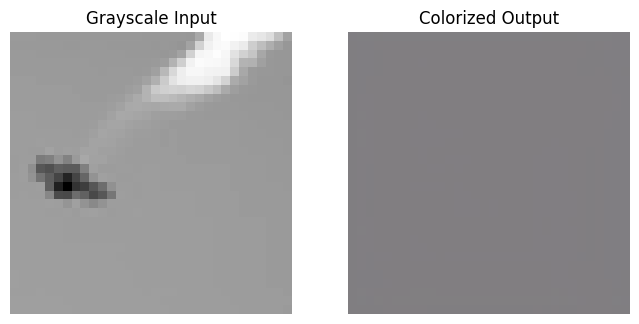

In [35]:
loss_history = train_model(learning_rate=0.001, batch_size=32, num_epochs=3)
